<ipython-input-19-b55f55526b59>:188: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
<ipython-input-19-b55f55526b59>:193: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name       | Type               | Params | Mode 
-----------------------------------------------------------
0  | input_bn   | BatchNorm1d        | 94     | train
1  | lstm1      | LST

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


MAPE: 0.1095
MAE: 0.0389
RMSE: 0.0493


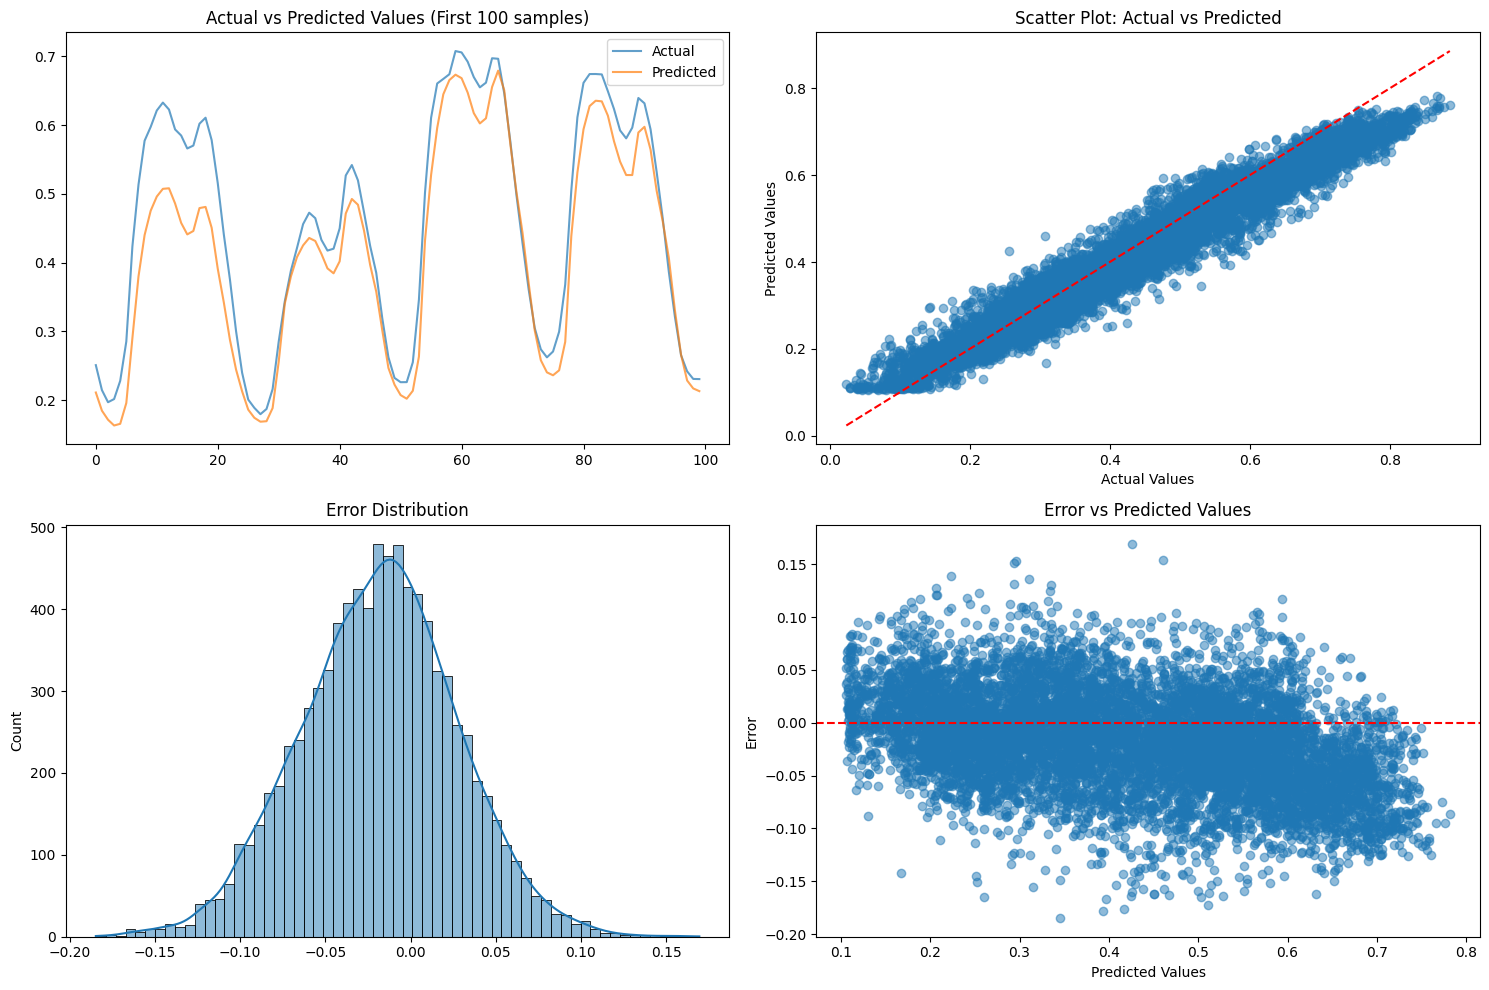

In [19]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import pytorch_lightning as pl
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

class LoadDataset(Dataset):
    def __init__(self, features, targets, sequence_length=24):
        self.sequence_length = sequence_length

        # Create sequences
        self.sequences = []
        self.targets_list = []

        for i in range(len(features) - sequence_length):
            seq = features[i:i + sequence_length]
            target = targets[i + sequence_length]
            self.sequences.append(seq)
            self.targets_list.append(target)

        self.sequences = torch.FloatTensor(self.sequences)
        self.targets_list = torch.FloatTensor(self.targets_list)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets_list[idx]

class EnhancedLSTMModel(pl.LightningModule):
    def __init__(
        self,
        input_size,
        hidden_size=128,
        num_layers=3,
        bidirectional=True,
        dropout=0.3,
        learning_rate=0.001,
        output_size=1
    ):
        super(EnhancedLSTMModel, self).__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate

        # Batch Normalization for input
        self.input_bn = nn.BatchNorm1d(input_size)

        # First LSTM layer
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )

        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size

        # Second LSTM layer
        self.lstm2 = nn.LSTM(
            input_size=lstm_output_size,
            hidden_size=hidden_size,  # Changed from hidden_size//2 to hidden_size
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        final_hidden_size = hidden_size * 2  # Because of bidirectional

        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=final_hidden_size,
            num_heads=4,
            dropout=dropout
        )

        # Fully connected layers
        self.fc1 = nn.Linear(final_hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)

        # Additional components
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(final_hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.activation = nn.GELU()

    def attention_forward(self, x):
        x = x.permute(1, 0, 2)
        attn_output, _ = self.attention(x, x, x)
        return attn_output.permute(1, 0, 2)

    def forward(self, x):
        # Input shape: [batch_size, seq_len, features]
        batch_size, seq_len, features = x.size()

        # Batch norm on features
        x_reshaped = x.view(-1, features)
        x_reshaped = self.input_bn(x_reshaped)
        x = x_reshaped.view(batch_size, seq_len, features)

        # First LSTM
        lstm1_out, _ = self.lstm1(x)

        # Second LSTM
        lstm2_out, _ = self.lstm2(lstm1_out)

        # Attention
        attended = self.attention_forward(lstm2_out)

        # Get last output and normalize
        out = attended[:, -1, :]  # Shape: [batch_size, final_hidden_size]
        out = self.layer_norm(out)

        # Fully connected layers
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc3(out)

        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat.squeeze(), y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat.squeeze(), y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat.squeeze(), y)
        self.log('test_loss', loss)
        return y_hat.squeeze(), y

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=0.01
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }

if __name__ == "__main__":
    # Read and prepare data
    df = pd.read_csv("/content/merged_cleaned.csv", delimiter=",")
    df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("[MWh]", "")
    df = df.drop('date', axis=1)
    df['Date'] = pd.to_datetime(df['Date'])
    df = pd.get_dummies(df, columns=['Holiday', 'day_name'], drop_first=True)
    df = df.fillna(method='ffill')

    # Add lagged features
    df['Last_Year'] = df['Gesamt_(Netzlast)__Berechnete_Auflösungen'].shift(365 * 24)
    df['Last_Week'] = df['Gesamt_(Netzlast)__Berechnete_Auflösungen'].shift(168)
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Scale features
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(df.drop(columns=['Date']))
    df_scaled = pd.DataFrame(scaled_features, columns=df.columns[1:])
    df_scaled['Date'] = df['Date']

    # Split data
    train = df_scaled[df_scaled['Date'] < '2023-10-30']
    test = df_scaled[df_scaled['Date'] >= '2023-10-30']
    val = train.tail(len(train)//10)
    train = train.head(len(train) - len(val))

    # Prepare data for LSTM
    target_col = 'Gesamt_(Netzlast)__Berechnete_Auflösungen'
    feature_cols = [col for col in df_scaled.columns if col != 'Date' and col != target_col]

    # Create datasets with sequences
    sequence_length = 24  # One day of hourly data

    train_dataset = LoadDataset(
        train[feature_cols].values,
        train[target_col].values,
        sequence_length=sequence_length
    )

    val_dataset = LoadDataset(
        val[feature_cols].values,
        val[target_col].values,
        sequence_length=sequence_length
    )

    test_dataset = LoadDataset(
        test[feature_cols].values,
        test[target_col].values,
        sequence_length=sequence_length
    )

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialize model
    input_size = len(feature_cols)
    model = EnhancedLSTMModel(input_size=input_size)

    # Setup callbacks
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath='checkpoints/',
        filename='lstm-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        mode='min'
    )

    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        min_delta=0.00,
        patience=10,
        verbose=True,
        mode='min'
    )

    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=100,
        callbacks=[checkpoint_callback, early_stop_callback],
        accelerator='auto',
        devices=1,
        logger=True
    )

    # Train model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate
    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            y_hat = model(x)
            predictions.extend(y_hat.squeeze().cpu().numpy())
            actuals.extend(y.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate metrics
    mape = mean_absolute_percentage_error(actuals, predictions)
    mae = np.mean(np.abs(predictions - actuals))
    rmse = np.sqrt(np.mean((predictions - actuals)**2))

    print(f'MAPE: {mape:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')

    # Visualizations
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(actuals[:100], label='Actual', alpha=0.7)
    plt.plot(predictions[:100], label='Predicted', alpha=0.7)
    plt.title('Actual vs Predicted Values (First 100 samples)')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot: Actual vs Predicted')

    plt.subplot(2, 2, 3)
    errors = predictions - actuals
    sns.histplot(errors, kde=True)
    plt.title('Error Distribution')

    plt.subplot(2, 2, 4)
    plt.scatter(predictions, errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Error')
    plt.title('Error vs Predicted Values')

    plt.tight_layout()
    plt.show()

In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Read the data
df = pd.read_csv("/content/merged_cleaned.csv", delimiter=",")

# Clean up column names
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("[MWh]", "")

# Drop 'date' column as it's redundant
df = df.drop('date', axis=1)

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# One-hot encode 'Holiday' and 'day_name' columns
df = pd.get_dummies(df, columns=['Holiday', 'day_name'], drop_first=True)

# Fill missing values with forward fill
df = df.fillna(method='ffill')

# Add Last Year Value (same day, last year)
df['Last_Year'] = df['Gesamt_(Netzlast)__Berechnete_Auflösungen'].shift(365 * 24)

# Add Last Week Value (same day, last week)
df['Last_Week'] = df['Gesamt_(Netzlast)__Berechnete_Auflösungen'].shift(168)

# Fill the NAs created by shifts with forward fill, then backward fill for any remaining
df = df.fillna(method='ffill').fillna(method='bfill')

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['Date']))

# Add back the scaled data to the DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=df.columns[1:])
df_scaled['Date'] = df['Date']

# Split the data into train, validation, and test
train = df_scaled[df_scaled['Date'] < '2023-10-30']
test = df_scaled[df_scaled['Date'] >= '2023-10-30']

# Optional: Split the train set into training and validation
val = train.tail(len(train)//10)
train = train.head(len(train) - len(val))

<ipython-input-12-524434a0df1a>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
<ipython-input-12-524434a0df1a>:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [7]:
df.columns

Index(['Date', 'Gesamt_(Netzlast)__Berechnete_Auflösungen',
       'Deutschland/Luxemburg_[€/MWh]_Originalauflösungen',
       'Biomasse__Berechnete_Auflösungen',
       'Wasserkraft__Berechnete_Auflösungen',
       'Wind_Offshore__Berechnete_Auflösungen',
       'Wind_Onshore__Berechnete_Auflösungen',
       'Photovoltaik__Berechnete_Auflösungen',
       'Sonstige_Erneuerbare__Berechnete_Auflösungen',
       'Kernenergie__Berechnete_Auflösungen',
       'Braunkohle__Berechnete_Auflösungen',
       'Steinkohle__Berechnete_Auflösungen', 'Erdgas__Berechnete_Auflösungen',
       'Pumpspeicher__Berechnete_Auflösungen_y',
       'Sonstige_Konventionelle__Berechnete_Auflösungen', 'hour', 'dayofweek',
       'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'date_offset',
       'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin',
       'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'is_workday',
       'Holiday_Christmas Day', 'Holiday_Day of German Unity',
       'Ho

In [15]:
import torch
import pytorch_lightning as pl
from torch import nn

class EnhancedLSTMModel(pl.LightningModule):
    def __init__(
        self,
        input_size,
        hidden_size=128,
        num_layers=3,
        bidirectional=True,
        dropout=0.3,
        learning_rate=0.001,
        output_size=1
    ):
        super(EnhancedLSTMModel, self).__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate

        # Batch Normalization for input
        self.input_bn = nn.BatchNorm1d(input_size)

        # Bidirectional LSTM layers
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )

        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size

        # Additional LSTM layer with different hidden size
        self.lstm2 = nn.LSTM(
            input_size=lstm_output_size,
            hidden_size=hidden_size // 2,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=4,
            dropout=dropout
        )

        # Fully connected layers with residual connections
        fc_input_size = hidden_size
        self.fc1 = nn.Linear(fc_input_size, fc_input_size // 2)
        self.fc2 = nn.Linear(fc_input_size // 2, fc_input_size // 4)
        self.fc3 = nn.Linear(fc_input_size // 4, output_size)

        # Additional components
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(fc_input_size)
        self.bn1 = nn.BatchNorm1d(fc_input_size // 2)
        self.bn2 = nn.BatchNorm1d(fc_input_size // 4)
        self.activation = nn.GELU()  # Using GELU instead of ReLU

    def attention_forward(self, x):
        # Prepare input for attention (seq_len, batch, hidden_size)
        x = x.permute(1, 0, 2)
        attn_output, _ = self.attention(x, x, x)
        return attn_output.permute(1, 0, 2)

    def forward(self, x):
        # Apply batch norm to input
        batch_size, seq_len, features = x.size()
        x = x.view(-1, features)
        x = self.input_bn(x)
        x = x.view(batch_size, seq_len, features)

        # First LSTM layer
        lstm1_out, _ = self.lstm1(x)

        # Second LSTM layer
        lstm2_out, _ = self.lstm2(lstm1_out)

        # Attention mechanism
        attended = self.attention_forward(lstm2_out)

        # Get the last output and apply layer norm
        out = attended[:, -1, :]
        out = self.layer_norm(out)

        # Fully connected layers with residual connections
        residual = out
        out = self.activation(self.bn1(self.fc1(out)))
        out = self.dropout(out)

        out = self.activation(self.bn2(self.fc2(out)))
        out = self.dropout(out)

        # Add residual connection after processing
        out = self.fc3(out) + self.fc3(residual)

        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat.squeeze(), y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat.squeeze(), y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat.squeeze(), y)
        self.log('test_loss', loss)
        return y_hat.squeeze(), y

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=0.01
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }
def train_model(train_loader, val_loader, input_size):
    # Initialize model
    model = EnhancedLSTMModel(
        input_size=input_size,
        hidden_size=128,
        num_layers=3,
        bidirectional=True,
        dropout=0.3,
        learning_rate=0.001
    )

    # Setup callbacks
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath='checkpoints/',
        filename='lstm-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        mode='min'
    )

    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        min_delta=0.00,
        patience=10,
        verbose=True,
        mode='min'
    )

    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=100,
        callbacks=[checkpoint_callback, early_stop_callback],
        accelerator='auto',  # Uses GPU if available
        devices=1,
        logger=True
    )

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    return model, trainer

# 2. Evaluate and visualize results
def evaluate_and_visualize(model, test_loader, scaler):
    # Get predictions
    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            y_hat = model(x)
            predictions.extend(y_hat.squeeze().cpu().numpy())
            actuals.extend(y.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # If you used StandardScaler or MinMaxScaler, inverse transform
    if scaler is not None:
        predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        actuals = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

    # Calculate metrics
    mape = mean_absolute_percentage_error(actuals, predictions)
    mae = np.mean(np.abs(predictions - actuals))
    rmse = np.sqrt(np.mean((predictions - actuals)**2))

    print(f'MAPE: {mape:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')

    # Create visualizations
    plt.figure(figsize=(15, 10))

    # 1. Actual vs Predicted
    plt.subplot(2, 2, 1)
    plt.plot(actuals[:100], label='Actual', alpha=0.7)
    plt.plot(predictions[:100], label='Predicted', alpha=0.7)
    plt.title('Actual vs Predicted Values (First 100 samples)')
    plt.legend()

    # 2. Scatter plot
    plt.subplot(2, 2, 2)
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot: Actual vs Predicted')

    # 3. Error Distribution
    plt.subplot(2, 2, 3)
    errors = predictions - actuals
    sns.histplot(errors, kde=True)
    plt.title('Error Distribution')

    # 4. Error vs Predicted
    plt.subplot(2, 2, 4)
    plt.scatter(predictions, errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Error')
    plt.title('Error vs Predicted Values')

    plt.tight_layout()
    plt.show()

    # Return metrics for further analysis
    return {
        'mape': mape,
        'mae': mae,
        'rmse': rmse,
        'predictions': predictions,
        'actuals': actuals
    }

# Usage example:
if __name__ == "__main__":
    # Assuming you have these variables ready:
    # train_loader, val_loader, test_loader, input_size, scaler

    # Train the model
    model, trainer = train_model(train_loader, val_loader, 48)

    # Evaluate and visualize
    metrics = evaluate_and_visualize(model, test_loader, scaler)

NameError: name 'ModelCheckpoint' is not defined

In [11]:
# Define the model and trainer
model = EnhancedLSTMModel(input_size=train_dataset.features.shape[1], hidden_layer_size=64)

# Initialize the TensorBoard logger
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs", name="lstm_model")

trainer = pl.Trainer(max_epochs=100, devices=1, accelerator="gpu", logger=logger)

# Train the model
trainer.fit(model, train_loader, val_loader)


TypeError: EnhancedLSTMModel.__init__() got an unexpected keyword argument 'hidden_layer_size'

In [ ]:
# Test the model on the test set
predictions, targets = [], []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_hat = model(x_batch)
        predictions.append(y_hat.squeeze().numpy())
        targets.append(y_batch.numpy())

predictions = np.concatenate(predictions)
targets = np.concatenate(targets)

# Calculate MAPE
mape = mean_absolute_percentage_error(targets, predictions)
print(f'MAPE on test data: {mape:.4f}')
